# **CS4973 Final Project**

## **Importing Libraries**

In [ ]:
pip install aequitas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.4/456.4 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.8/727.8 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.0 MB/s eta 0:00:00
  Created wheel for Flas

In [ ]:
# Preprocessing imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# .py file from original GitHub
from dataset import NIH

# Pytorch libraries
import torch
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Evaluation metric imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

# Fairness evaluation imports
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

## **Preprocessing and Cleaning Data**

In [ ]:
# Loading in images (zip method, as folder was too large)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/My Drive/images.zip"

In [ ]:
# Path to the folder containing PNG images
folder_path = "images"

# List of all PNG files in the folder
png_files = [f for f in os.listdir(folder_path) if f.endswith(".png")]

In [ ]:
# Data entries for all NIH images
data_entry_df = pd.read_csv("Data_Entry_2017_v2020.csv")

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Create buckets for age group
bins = [0, 18, 30, 50, 100]
labels = [f'Age {i}-{j}' for i, j in zip(bins[:-1], bins[1:])]
data_entry_df['Age Group'] = pd.cut(data_entry_df['Patient Age'], bins=bins, labels=labels)

# Encode 'Age Group' to be numerical data
label_encoder = LabelEncoder()
data_entry_df['Age Group Encoded'] = label_encoder.fit_transform(data_entry_df['Age Group'])

data_entry_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Age Group,Age Group Encoded
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,Age 50-100,3
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,Age 50-100,3
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,Age 50-100,3
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,Age 50-100,3
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,Age 50-100,3


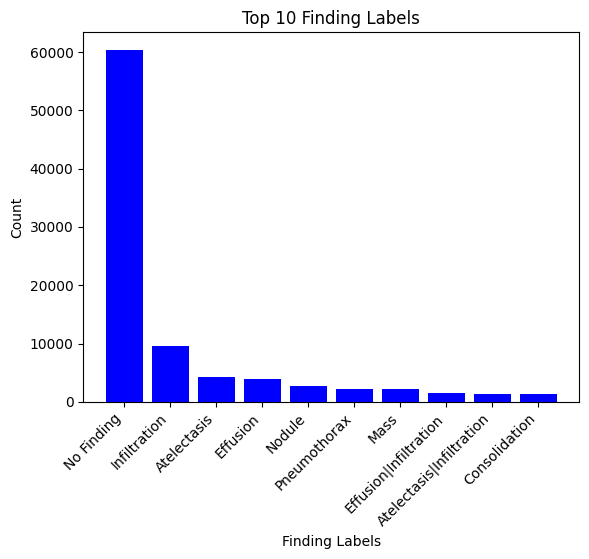

In [ ]:
# Representing the counts of top 10 finding labels
top_finding_labels = data_entry_df['Finding Labels'].value_counts().head(10)

# Plotting
plt.bar(top_finding_labels.index, top_finding_labels.values, color='blue')
plt.xlabel('Finding Labels')
plt.ylabel('Count')
plt.title('Top 10 Finding Labels')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Dataframe for subset of images downloaded from NIH website
start_idx = "00006585_007"
end_idx = "00009232_004"

subset_df = data_entry_df[
    (data_entry_df["Image Index"] >= start_idx)
    & (data_entry_df["Image Index"] <= end_idx)
]

subset_df = subset_df.drop(
    columns=["OriginalImage[Width", "Height]", "OriginalImagePixelSpacing[x", "y]"]
)

In [ ]:
# Add binary columns for each pathology to match NIH model
pathologies = [
    "Atelectasis",
    "Cardiomegaly",
    "Effusion",
    "Infiltration",
    "Mass",
    "Nodule",
    "No Finding",
    "Pneumonia",
    "Pneumothorax",
    "Consolidation",
    "Edema",
    "Emphysema",
    "Fibrosis",
    "Pleural_Thickening",
    "Hernia",
]

# Converts labels to represent whether it exists for that image
for p in pathologies:
    subset_df[p] = subset_df["Finding Labels"].str.contains(p).astype(int)

# Split the data into training and validation sets, find the size of each
train, val = train_test_split(subset_df, test_size=0.4)
print(train.shape)
print(val.shape)

(6000, 24)
(4000, 24)


In [ ]:
# Pytorch dataset and dataloader for training data
transform_list = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((128,128))]
)

# DataLoader handles batching and shuffling of the data during training
train_dataset = NIH(train, folder_path, transform=transform_list)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
print("Number of Training Samples:", len(train_dataset))
print("Number of Batches:", len(train_loader))

Number of Training Samples: 6000
Number of Batches: 375


## **Training Model, Determining Loss**

In [ ]:
# Model from NIH repo
model = models.densenet121(pretrained=True)
num_features = model.classifier.in_features

n_labels = 2
model.classifier = torch.nn.Linear(num_features, n_labels)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 54.6MB/s]


In [ ]:
# Loss function, optimizer - Cross Entropy is normally used for classification
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 0.5e-3
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [ ]:
# Training loop - updates model weights during training phase

def run_one_epoch(model, data_loader, loss_fn, optimizer, phase="train", save_path=None):
    running_loss = 0.0
    last_loss = 0.0
    losses = []

    for i, data in enumerate(data_loader):
        # Every data instance has an image, label, and the "Image Index"
        images, labels, _ = data

        if phase == "train":
            optimizer.zero_grad() # zero gradients for every batch
            model.train()
            outputs = model(images)  # make predictions
        elif phase == "val":
            model.eval()
            with torch.no_grad():
                outputs = model(images)  # make predictions

        loss = loss_fn(outputs, labels)
        if phase == "train":
            loss.backward()
            optimizer.step()  # update weights

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10  # loss per batch
            print(f"Batch {i+1} Loss: {last_loss}")
            losses.append(last_loss)
            running_loss = 0.0

        if save_path is not None:
            torch.save(model.state_dict(), save_path)

    return losses

In [ ]:
# Create a directory in your Google Drive
drive.mount('/content/gdrive')
save_dir = '/content/gdrive/MyDrive'
os.makedirs(save_dir, exist_ok=True)

# Define the file name for model parameters
save_filename = 'model_batch_loss.pth'
save_path = os.path.join(save_dir, save_filename)

# Now you can use `save_path` in your training loop
epochs = 1

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_losses = run_one_epoch(model, train_loader, loss_fn, optimizer, phase="train", save_path=save_path)

Mounted at /content/gdrive
Epoch 1/1


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Batch 10 Loss: 0.7524232685565948
Batch 20 Loss: 0.7149586260318757
Batch 30 Loss: 0.7431390643119812
Batch 40 Loss: 0.7681475162506104
Batch 50 Loss: 0.6669314801692963
Batch 60 Loss: 0.7409322649240494
Batch 70 Loss: 0.699104118347168
Batch 80 Loss: 0.6490255236625672
Batch 90 Loss: 0.6159456461668015
Batch 100 Loss: 0.6457529842853547
Batch 110 Loss: 0.6185824394226074
Batch 120 Loss: 0.7156467497348785
Batch 130 Loss: 0.5979071408510208
Batch 140 Loss: 0.6320990324020386
Batch 150 Loss: 0.6974950850009918
Batch 160 Loss: 0.6755877733230591
Batch 170 Loss: 0.5899833679199219
Batch 180 Loss: 0.6746047616004944
Batch 190 Loss: 0.6142614781856537
Batch 200 Loss: 0.6058786600828171
Batch 210 Loss: 0.6199163556098938
Batch 220 Loss: 0.6455938339233398
Batch 230 Loss: 0.5970417499542237
Batch 240 Loss: 0.6741994500160218
Batch 250 Loss: 0.6031461954116821
Batch 260 Loss: 0.6093381762504577
Batch 270 Loss: 0.6485198646783829
Batch 280 Loss: 0.6367103636264801
Batch 290 Loss: 0.575856924057

In [ ]:
# Load the model parameters
model_state_dict = torch.load(save_path)

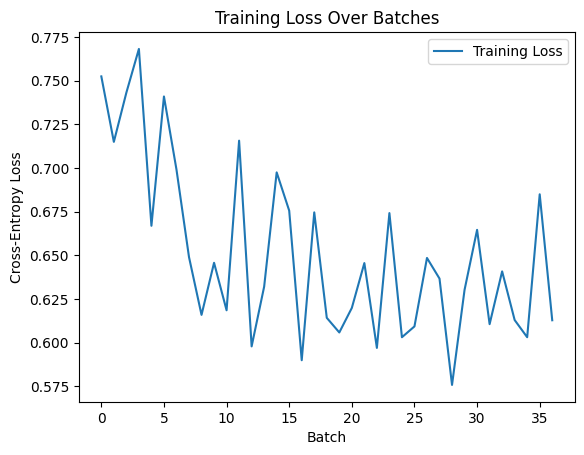

In [ ]:
# Visualize cross-entropy loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training Loss Over Batches')
plt.legend()
plt.show()

# **Evaluating the Model**

In [ ]:
# Make predictions and evaluate
test_dataset = NIH(val, folder_path, transform=transform_list)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

all_preds = []
for i, data in enumerate(test_loader):
    images, labels, _ = data

    model.eval()
    with torch.no_grad():
        outputs = model(images)

    preds = torch.argmax(outputs, -1)
    all_preds.append(preds)

val.loc[:, "preds"] = np.concatenate(all_preds)
print("Accuracy Score:", accuracy_score(val["No Finding"], val["preds"]))

Accuracy Score: 0.60575


In [ ]:
# Accuracy per gender (males and females)
genders = val['Patient Gender'].unique()

for gender in genders:
    # Create a subset of data for the current gender
    gender_subset = val[val['Patient Gender'] == gender]

    # Extract labels and predictions for the subset
    subset_labels = gender_subset['No Finding']
    subset_preds = gender_subset['preds']

    # Calculate accuracy for the current gender
    accuracy = accuracy_score(subset_labels, subset_preds)
    print(f"Accuracy for {gender}: {accuracy}")

Accuracy for F: 0.6144643828167482
Accuracy for M: 0.5983341045812124


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming you have already defined the age groups and encoded them in the DataFrame

# Accuracy per age group
age_groups_encoded = sorted(val['Age Group Encoded'].unique())

for age_group_encoded in age_groups_encoded:
    # Create a subset of data for the current age group
    age_group_subset = val[val['Age Group Encoded'] == age_group_encoded]

    # Extract labels and predictions for the subset
    subset_labels = age_group_subset['No Finding']
    subset_preds = age_group_subset['preds']

    # Get the corresponding age range for the group
    age_range = age_group_subset['Age Group'].iloc[0]

    # Calculate accuracy for the current age group
    accuracy = accuracy_score(subset_labels, subset_preds)
    print(f"Age Group Code: {age_group_encoded}, Age Range: {age_range}, Accuracy: {accuracy}")

Age Group Code: 0, Age Range: Age 0-18, Accuracy: 0.5752688172043011
Age Group Code: 1, Age Range: Age 18-30, Accuracy: 0.6548507462686567
Age Group Code: 2, Age Range: Age 30-50, Accuracy: 0.6212737127371274
Age Group Code: 3, Age Range: Age 50-100, Accuracy: 0.58157602663707


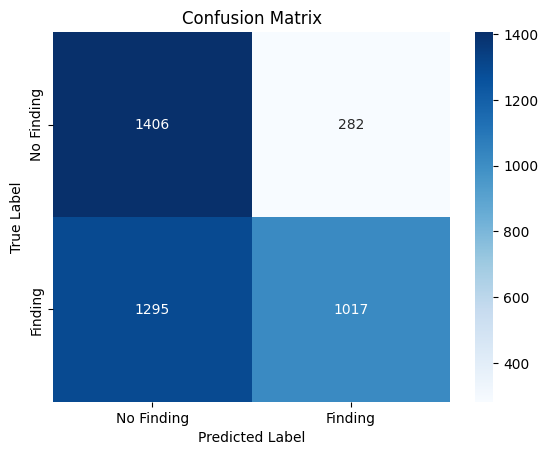

Classification Report:
              precision    recall  f1-score   support

  No Finding       0.52      0.83      0.64      1688
     Finding       0.78      0.44      0.56      2312

    accuracy                           0.61      4000
   macro avg       0.65      0.64      0.60      4000
weighted avg       0.67      0.61      0.60      4000



In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(val["No Finding"], val["preds"])

# Plot the confusion matrix using seaborn library
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Finding', 'Finding'], yticklabels=['No Finding', 'Finding'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(val["No Finding"], val["preds"], target_names=['No Finding', 'Finding']))

In [ ]:
# Calculating false negative rate - represents underdiagnosis
tn, fp, fn, tp = confusion_matrix(val["No Finding"], val["preds"]).ravel()
false_negative_rate = fn / (fn + tp)

print("False Negative Rate:", false_negative_rate)

False Negative Rate: 0.5601211072664359


AUC Score: 0.6364086406795783


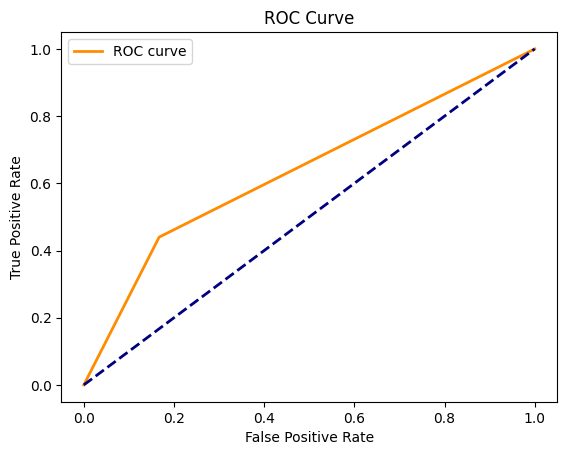

In [ ]:
# Concatenate predicted probabilities
all_probs = torch.cat(all_preds).cpu().numpy()
labels = val["No Finding"].to_numpy()

# Calculate AUC score
auc_score = roc_auc_score(labels, all_probs)
print("AUC Score:", auc_score)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(labels, all_probs)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# **Fairness Evaluation Techniques**

In [ ]:
# Prepare data for Aequitas
aqdf = val.copy()
aqdf['score'] = val['preds']
aqdf['label_value'] = val['No Finding']

aqdf.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,Age Group,Age Group Encoded,Atelectasis,...,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia,preds,score,label_value
30523,00007964_000.png,No Finding,0,7964,52,F,AP,Age 50-100,3,0,...,0,0,0,0,0,0,0,0,0,1
28083,00007321_012.png,No Finding,12,7321,57,M,PA,Age 50-100,3,0,...,0,0,0,0,0,0,0,0,0,1
28440,00007420_004.png,No Finding,3,7420,19,M,PA,Age 18-30,1,0,...,0,0,0,0,0,0,0,1,1,1
28027,00007308_001.png,No Finding,1,7308,49,F,PA,Age 30-50,2,0,...,0,0,0,0,0,0,0,0,0,1
34294,00009007_001.png,Nodule,1,9007,50,M,PA,Age 30-50,2,0,...,0,0,0,0,0,0,0,1,1,0


**For Gender**

In [102]:
attributes_and_reference_groups={'Patient Gender':'M'}
attributes_to_audit = list(attributes_and_reference_groups.keys())

In [103]:
metrics = ['precision','for']
disparity_tolerance = 1.25

In [104]:
# Initialize Aequitas
g = Group()
b = Bias()

# get_crosstabs returns a dataframe of the group counts and group value bias metrics.
xtab, _ = g.get_crosstabs(aqdf, attr_cols=attributes_to_audit)
bdf = b.get_disparity_predefined_groups(xtab, original_df=aqdf, ref_groups_dict=attributes_and_reference_groups)

get_disparity_predefined_group()


In [105]:
# baseline value always passes
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [106]:
ap.disparity(bdf, metrics, 'Patient Gender', fairness_threshold = disparity_tolerance)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

**For Age Groups**

In [107]:
# Chosen age group as baseline because it has the highest accuracy
attributes_and_reference_groups={'Age Group':'Age 18-30'}
attributes_to_audit = list(attributes_and_reference_groups.keys())

In [108]:
metrics = ['precision','for']
disparity_tolerance = 1.25

In [109]:
aqdf['Age Group'] = aqdf['Age Group'].astype(str)

In [110]:
# Initialize Aequitas
g = Group()
b = Bias()

# get_crosstabs returns a dataframe of the group counts and group value bias metrics.
xtab, _ = g.get_crosstabs(aqdf, attr_cols=attributes_to_audit)
bdf = b.get_disparity_predefined_groups(xtab, original_df=aqdf, ref_groups_dict=attributes_and_reference_groups)

get_disparity_predefined_group()


In [111]:
# baseline value always passes
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [112]:
ap.disparity(bdf, metrics, 'Age Group', fairness_threshold = disparity_tolerance)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)